**7장 – 앙상블 학습과 랜덤 포레스트**

_이 노트북은 7장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/DCC/ML/handson-ml2/datasets"

In [3]:
import os
os.chdir(path)

In [4]:
os.getcwd()

'/content/drive/MyDrive/DCC/ML/handson-ml2/datasets'

In [5]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 7.1 투표기반 분류기

In [113]:
np.arange(1, 10001)

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [114]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


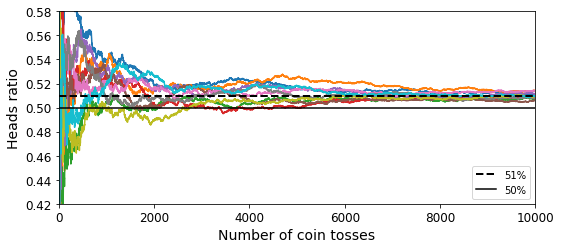

In [115]:
plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth = 2, label = "51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label = "50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(375, 2)
(125, 2)
(375,)
(125,)


**노트**: 향후 버전을 위해 사이킷런에서 기본 값이 될 `solver = "lbfgs"`, `n_estimators = 100`, `gamma = "scale"`로 지정합니다.

In [118]:
from sklearn.ensemble import RandomForestClassifier   # 랜덤 포레스트 분류기
from sklearn.ensemble import VotingClassifier         # 투표 기반 분류기
from sklearn.linear_model import LogisticRegression   # 로지스틱 회귀
from sklearn.svm import SVC                           # 서포트 벡터 머신 분류기

log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')    # voting = "hard" : 직접 투표(다수결 투표로 정해지는 분류기)
                        # voting = "soft" : 간접 투표(개별 분류기의 예측을 평균 내어 호가률이 가장 높은 클래스를 예측)

In [119]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [120]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)  # 학습된 모델의 예측값을 출력
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**노트**: 사이킷런 알고리즘이 이따금 업데이트되기 때문에 이 노트북의 결과가 책과 조금 다를 수 있습니다.

간접 투표:

In [121]:
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [122]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 7.2 배깅과 페이스팅

## 7.2.1 사이킷런의 배깅과 페이스팅
- 배깅(Bootstrap Aggregating; Bagging) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
  - 부트스트랩(Bootstrap) : 중복 허용
- 페이스팅(Pasting) : 훈련 세트에서 중복을 허용하지 않고 샘플링하는 방식

In [123]:
X_train.shape

(375, 2)

In [124]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),     # 의사결정나무 분류기
    n_estimators = 500,           # 사용할 Tree의 수
    max_samples = 100,            # 최대 샘플의 수
    bootstrap = True,             # 중복 허용 -> 배깅
    random_state = 42)            # 난수 초기값
bag_clf.fit(X_train, y_train)     # 모델 훈련
y_pred = bag_clf.predict(X_test)  # 학습된 모델의 예측값을 출력

- BaggingClassifier의 Test set에 대한 정확도

In [125]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)        # 학습된 모델의 예측값을 출력
print(accuracy_score(y_test, y_pred))   # 학습된 모델의 테스트 성능 출력

0.904


- BaggingClassifier의 Train set에 대한 정확도

In [126]:
y_pred_train = bag_clf.predict(X_train)
print(accuracy_score(y_train, y_pred_train))

0.9386666666666666


- Decision Tree의 Test set에 대한 정확도

In [127]:
tree_clf = DecisionTreeClassifier(random_state = 42)  # 의사결정나무로 만듦
tree_clf.fit(X_train, y_train)                        # fitting을 함
y_pred_tree = tree_clf.predict(X_test)                # 학습을 시킴
print(accuracy_score(y_test, y_pred_tree))            # 정확도 검증

0.856


- Decision Tree의 Train set에 대한 정확도

In [128]:
y_pred_tree_train = tree_clf.predict(X_train)
print(accuracy_score(y_train, y_pred_tree_train))

1.0


In [132]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.5, contour = True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha = 0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha = alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha = alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize = 18)
    plt.ylabel(r"$x_2$", fontsize = 18, rotation = 0)

그림 저장: decision_tree_without_and_with_bagging_plot


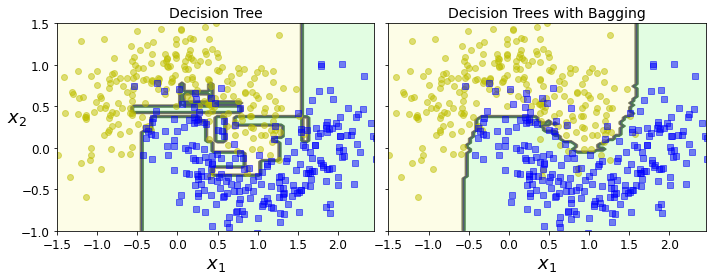

In [133]:
fix, axes = plt.subplots(ncols = 2, figsize = (10,4), sharey = True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize = 14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize = 14)
plt.ylabel("")

save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## 7.2.2 OOB(Out-Of-Bag) 평가

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500,
    bootstrap = True,
    oob_score = True,
    random_state = 42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
bag_clf.oob_decision_function_

# 7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier은 특성 샘플링도 지원
  - 샘플링은 `max_features`, `bootstrap_features` 두 매개변수로 조절
  - 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용

- **랜덤 패치 방식** : 훈련 특성과 샘플을 모두 샘플링
- **서브스페이스 방식** : 훈련 샘플을 모두 사용하고 특성은 샘플링
  - 훈련 샘플을 모두 사용 : `bootstrap = False`, `max_sample = 1.0`으로 설정
  - 특성은 샘플링 : `bootstrap_features = True`, `max_feature`은 1보다 작게 설정


# 7.4 랜덤 포레스트

BaggingClassifier을 활용하여 RandomForestClassifier을 만들기

In [108]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "sqrt",
                           max_leaf_nodes = 16),    # 최대 리프 노드 : 16개
    n_estimators = 500,                             # 트리의 수
    random_state = 42)

In [109]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [134]:
print(accuracy_score(y_test, y_pred)) # 정확도 검증

0.904


In [135]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500,
                                 max_leaf_nodes = 16,
                                 random_state = 42)
rnd_clf.fit(X_train, y_train)       # 랜덤포레스트 분류기에 fitting

y_pred_rf = rnd_clf.predict(X_test) # 학습된 모델의 예측값을 출력

In [136]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

0.976

In [137]:
rnd_clf.feature_importances_  # 특성 중요도

array([0.42253629, 0.57746371])

## 7.4.1 엑스트라 트리

- 랜덤포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
- 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 **후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택**
- **익스트림 랜덤트리 앙상블** : 극단적으로 무작위한 트리의 랜덤 포레스트
  - **엑스트라 트리**라고도 부름
  - `ExtraTreesClassifier`

## 7.4.2 특성 중요도

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
iris["feature_names"]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [31]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [32]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

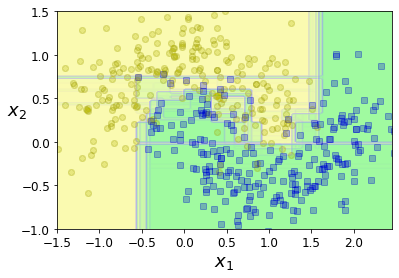

In [33]:
plt.figure(figsize = (6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42 + i) # 난수를 바꿔가며
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.02, contour = False)

plt.show()

In [138]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

In [139]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [140]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation = "nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


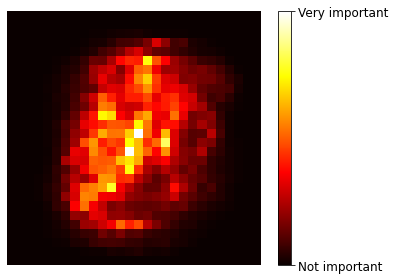

In [141]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 7.5 부스팅(Boosting)

- **부스팅** : 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법

## 7.5.1 에이다부스트(Adaptive Boosting; AdaBoost)

- **에이다부스트** : 약한 분류기들이 상호보완 하도록 순차적으로 학습하고, 이들을 조합하여 최종적으로 강한 분류기의 성능을 향상시키는 것

In [142]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),                        # 의사결정나무 분류기 / 최대 깊이 : 1
    n_estimators = 200,                                           # Tree의 수 : 200
    algorithm = "SAMME.R", learning_rate = 0.5, random_state=42)  # 학습률 : 0.5
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

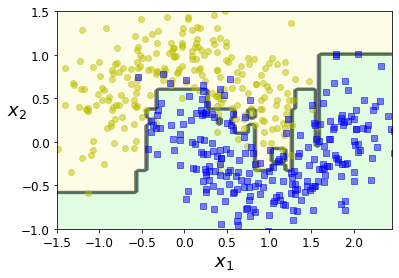

In [143]:
plot_decision_boundary(ada_clf, X, y)

Adaboost 모델의 Train Set 정확도와 Test Set 정확도 계산

In [144]:
y_pred_adaboost_train = ada_clf.predict(X_train)
print("Adaboost 모델의 Train set에 대한 정확도 : ", accuracy_score(y_train, y_pred_adaboost_train))

y_pred_adaboost_test = ada_clf.predict(X_test)
print("Adaboost 모델의 Test set에 대한 정확도 : ", accuracy_score(y_test, y_pred_adaboost_test))

Adaboost 모델의 Train set에 대한 정확도 :  0.968
Adaboost 모델의 Test set에 대한 정확도 :  0.896


그림 저장: boosting_plot


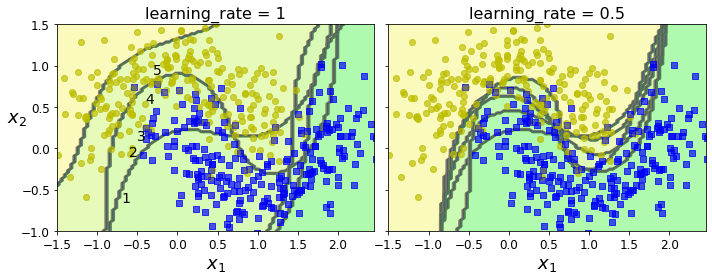

In [145]:
m = len(X_train)

fix, axes = plt.subplots(ncols = 2, figsize = (10,4), sharey = True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel = "rbf", C = 0.2, gamma = 0.6, random_state = 42)
        svm_clf.fit(X_train, y_train, sample_weight = sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)                        # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)                 # equation 7-3
        sample_weights /= sample_weights.sum()                             # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha = 0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize = 16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize = 14)
        plt.text(-0.6, -0.10, "2", fontsize = 14)
        plt.text(-0.5,  0.10, "3", fontsize = 14)
        plt.text(-0.4,  0.55, "4", fontsize = 14)
        plt.text(-0.3,  0.90, "5", fontsize = 14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

## 7.5.2 그레이디언트 부스팅(Gradient Boosting)

- **그레이디언트 부스팅** : 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여오차**에 새로운 예측기를 학습

In [155]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [156]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [157]:
y2 = y - tree_reg1.predict(X) # 첫번째 예측기에서 생긴 잔여 오차
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X, y2)  # 모델에 학습

DecisionTreeRegressor(max_depth=2, random_state=42)

In [158]:
y3 = y2 - tree_reg2.predict(X)  # 두번째 예측기에서 생긴 잔여 오차
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)  # 모델에 학습

DecisionTreeRegressor(max_depth=2, random_state=42)

In [159]:
X_new = np.array([[0.8]])
X_new

array([[0.8]])

In [160]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [161]:
def plot_predictions(regressors, X, y, axes, label = None,
                     style = "r-", data_style = "b.", data_label = None) :
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label = data_label)
    plt.plot(x1, y_pred, style, linewidth = 2, label = label)
    if label or data_label:
        plt.legend(loc = "upper center", fontsize = 16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


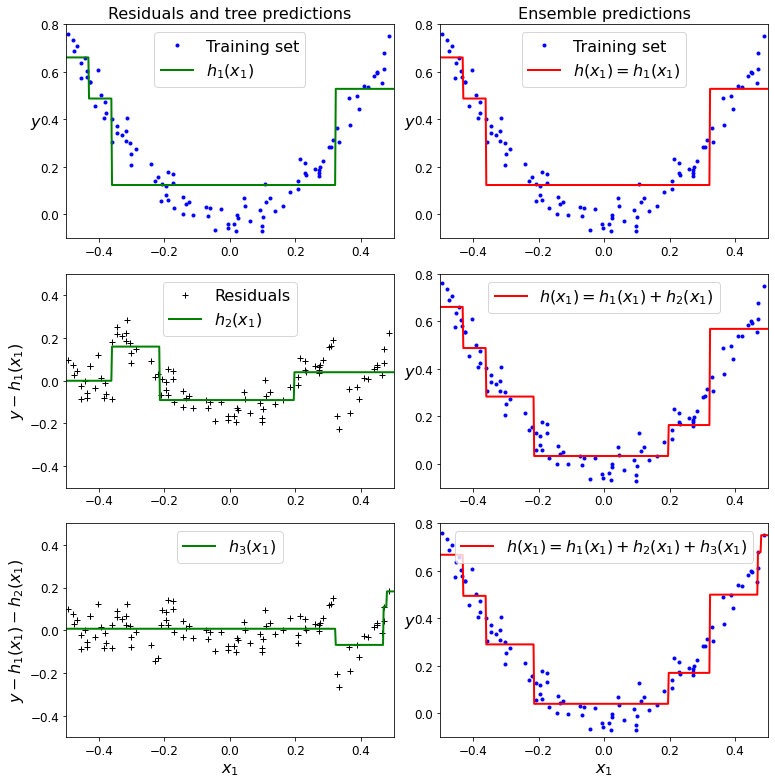

In [162]:
plt.figure(figsize = (11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "$h_1(x_1)$", style = "g-", data_label = "Training set")
plt.ylabel("$y$", fontsize = 16, rotation = 0)
plt.title("Residuals and tree predictions", fontsize = 16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "$h(x_1) = h_1(x_1)$", data_label = "Training set")
plt.ylabel("$y$", fontsize = 16, rotation = 0)
plt.title("Ensemble predictions", fontsize = 16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes = [-0.5, 0.5, -0.5, 0.5], label = "$h_2(x_1)$", style = "g-", data_style = "k+", data_label = "Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize = 16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize = 16, rotation = 0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes = [-0.5, 0.5, -0.5, 0.5], label = "$h_3(x_1)$", style = "g-", data_style = "k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize = 16)
plt.xlabel("$x_1$", fontsize = 16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize = 16)
plt.ylabel("$y$", fontsize = 16, rotation = 0)

save_fig("gradient_boosting_plot")
plt.show()

In [163]:
from sklearn.ensemble import GradientBoostingRegressor  # 그레이디언트부스팅 회귀

gbrt = GradientBoostingRegressor(max_depth = 2,
                                 n_estimators = 3,
                                 learning_rate = 1.0,
                                 random_state = 42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [164]:
gbrt_slow = GradientBoostingRegressor(max_depth = 2,
                                      n_estimators = 200, 
                                      learning_rate = 0.1,
                                      random_state = 42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


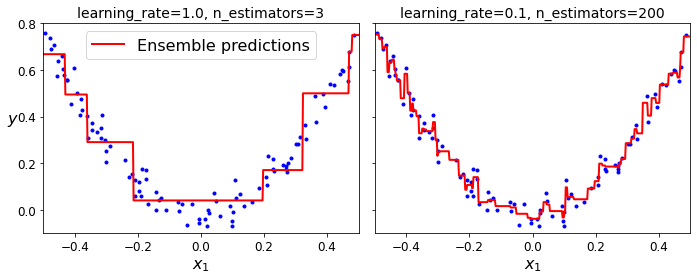

In [165]:
fix, axes = plt.subplots(ncols = 2, figsize = (10,4), sharey = True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize = 14)
plt.xlabel("$x_1$", fontsize = 16)
plt.ylabel("$y$", fontsize = 16, rotation = 0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes = [-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize = 14)
plt.xlabel("$x_1$", fontsize = 16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## 조기 종료를 사용한 그래디언트 부스팅

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [58]:
bst_n_estimators

56

In [59]:
errors

[0.03976434066090687,
 0.03301153878946109,
 0.027663386192027795,
 0.023337263188229852,
 0.020390590545872743,
 0.017820174421765502,
 0.015262814214454865,
 0.013228529533567415,
 0.011758450328306618,
 0.010288335529306629,
 0.009391268210618017,
 0.008605826199167754,
 0.007745553291052828,
 0.007083571270654957,
 0.006766296135021012,
 0.006116142333014483,
 0.005770219779341232,
 0.005416351332327169,
 0.0050727394710244665,
 0.0048159263120028765,
 0.004357591913537005,
 0.004192866645244622,
 0.0039670672414243964,
 0.0038463154458755833,
 0.0037468374981679863,
 0.003530909744387239,
 0.0034677533859285626,
 0.0033882676886440523,
 0.003224220772589744,
 0.0031883136637545035,
 0.003166151135979498,
 0.003072276914292378,
 0.003024919266015998,
 0.002991089248190895,
 0.002957301355498197,
 0.0028890741785044197,
 0.0028849656803361795,
 0.0028902935070124736,
 0.002836717946434534,
 0.0028151139950619727,
 0.002805906789900023,
 0.002769821491376303,
 0.002775136129921357,
 

In [60]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


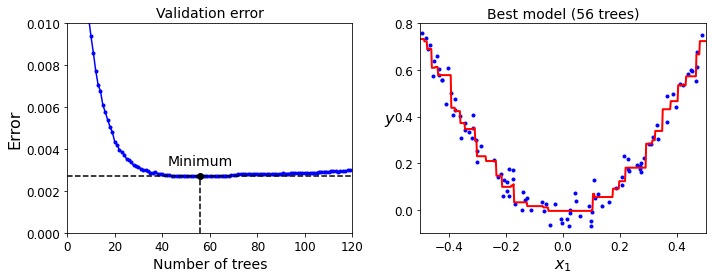

In [61]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [62]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [63]:
print(gbrt.n_estimators)

61


In [64]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost 사용하기

In [65]:
import xgboost

In [66]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [67]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

[11:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [68]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], 
                eval_metric = 'mae',
                early_stopping_rounds=30)
    
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.245293
Will train until validation_0-mae hasn't improved in 30 rounds.
[1]	validation_0-mae:0.219651
[2]	validation_0-mae:0.196771
[3]	validation_0-mae:0.176096
[4]	validation_0-mae:0.157525
[5]	validation_0-mae:0.141027
[6]	validation_0-mae:0.125683
[7]	validation_0-mae:0.113036
[8]	validation_0-mae:0.102303
[9]	validation_0-mae:0.094072
[10]	validation_0-mae:0.08566
[11]	validation_0-mae:0.077624
[12]	validation_0-mae:0.071632
[13]	validation_0-mae:0.06562
[14]	validation_0-mae:0.060505
[15]	validation_0-mae:0.055635
[16]	validation_0-mae:0.051901
[17]	validation_0-mae:0.049127
[18]	validation_0-mae:0.047101
[19]	validation_0-mae:0.044821
[20]	validation_0-mae:0.042828
[21]	validation_0-mae:0.041187
[22]	validation_0-mae:0.040501
[23]	validation_0-mae:0.03983
[24]	validation_0-mae:0.039131
[25]	validation_0-mae:0.038591
[26]	validation_

In [69]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [70]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10 loops, best of 5: 26.3 ms per loop


# 연습문제 해답

## 문제 1. to 7.

부록 A 참조.

## 문제 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했습니다.

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다._

In [73]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [74]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [75]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [76]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9639]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요._

In [77]:
from sklearn.ensemble import VotingClassifier

In [78]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [79]:
voting_clf = VotingClassifier(named_estimators)

In [80]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [81]:
voting_clf.score(X_val, y_val)

0.9708

In [82]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9639]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를  제외시킬 수 있습니다:

In [83]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

예측기 목록이 업데이트되었습니다:

In [84]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

하지만 훈련된 예측기 목록은 업데이트되지 않습니다:

In [85]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다:

In [86]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 보죠:

In [87]:
voting_clf.score(X_val, y_val)

0.9736

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정하면 됩니다:

In [88]:
voting_clf.voting = "soft"

In [89]:
voting_clf.score(X_val, y_val)

0.97

이 경우는 직접 투표 방식이 낫네요.

_앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [90]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9704

In [91]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9604]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

## 문제 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요._

In [92]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [93]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [94]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [95]:
rnd_forest_blender.oob_score_

0.9684

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [96]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [97]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [98]:
from sklearn.metrics import accuracy_score

In [99]:
accuracy_score(y_test, y_pred)

0.9671

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.